<a href="https://colab.research.google.com/github/wse2271/-Keras-study/blob/main/Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.fashion_mnist import load_data
from __future__ import print_function
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, ZeroPadding2D, Add, concatenate
from keras.layers import MaxPool2D, AveragePooling2D, Input, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
#label one_hot 1회만
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)


In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 15

In [ ]:
val_samples = 10000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE))
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE))

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [ ]:
print(new_x_train.shape)
print(new_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 28, 28, 1)
(50000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<ZipDataset shapes: (((None, 28, 28, 1), (None, 10)), ((None, 28, 28, 1), (None, 10))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32))>
<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [ ]:
def mix_up(ds_one, ds_two, alpha=0.2):
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.04982218146324158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.950177788734436, 0.0]
[0.0, 0.0, 0.0, 0.004822504241019487, 0.0, 0.9951775074005127, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9050279855728149, 0.0, 0.09497201442718506, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.8172502517700195, 0.0, 0.0, 0.0, 0.18274976313114166, 0.0, 0.0]
[0.0, 0.9999765753746033, 2.3407210392178968e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9999800324440002, 0.0, 0.0, 0.0, 0.0, 1.996755599975586e-05, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9943351149559021, 0.0, 0.0, 0.005664881318807602, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.9999980330467224, 0.0, 0.0, 0.0, 1.9669532775878906e-06, 0.0]


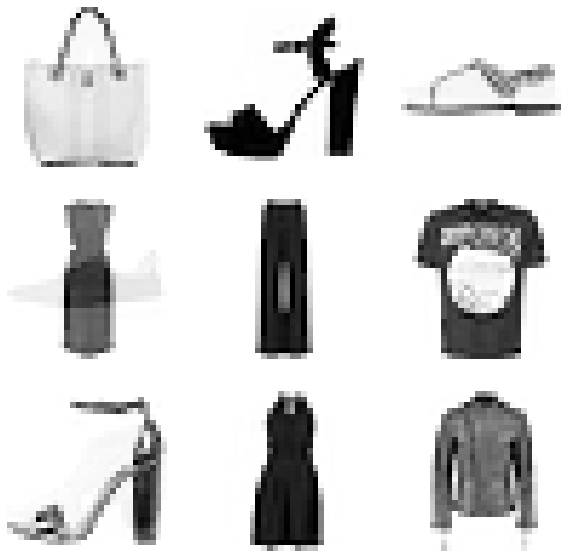

In [ ]:
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO)

sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
def naive_inception_block(prev_layer) :
  conv1x1 = Conv2D(64, kernel_size=(1,1), padding = 'same', activation = 'relu')(prev_layer)
  conv3x3 = Conv2D(64, kernel_size=(3,3), padding = 'same', activation = 'relu')(prev_layer)
  conv5x5 = Conv2D(64, kernel_size=(5,5), padding = 'same', activation = 'relu')(prev_layer)
  max_pool = MaxPooling2D((2,2), strides = (1,1), padding='same')(prev_layer)

  return concatenate([conv1x1, conv3x3, conv5x5, max_pool], axis=1)

In [ ]:
model = Sequential()
 
input = Input(shape=(28, 28, 1))
output = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(input)
output = Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid')(output)
output = naive_inception_block(output)
output = Dropout(0.3)(output)

output = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(output)
output = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid')(output)
output = MaxPool2D(pool_size=(2,2), strides=(2,2))(output)
output = Dropout(0.3)(output)


output = Flatten()(output)
output = Dense(units=10, activation='softmax')(output)
 
model = Model(inputs=[input], outputs=output)
  
 
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                metrics=['acc']
                )  
  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 2,098,122
Trainable params: 2,098,122
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
hist = model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/15
391/391 [==============================] - 36s 48ms/step - loss: 0.7212 - acc: 0.8118 - val_loss: 0.2747 - val_acc: 0.9074
Epoch 2/15
391/391 [==============================] - 18s 45ms/step - loss: 0.5277 - acc: 0.8712 - val_loss: 0.2388 - val_acc: 0.9189
Epoch 3/15
391/391 [==============================] - 18s 45ms/step - loss: 0.4803 - acc: 0.8884 - val_loss: 0.2263 - val_acc: 0.9281
Epoch 4/15
391/391 [==============================] - 18s 45ms/step - loss: 0.4488 - acc: 0.9005 - val_loss: 0.2023 - val_acc: 0.9264
Epoch 5/15
391/391 [==============================] - 18s 45ms/step - loss: 0.4221 - acc: 0.9110 - val_loss: 0.1944 - val_acc: 0.9327
Epoch 6/15
391/391 [==============================] - 18s 45ms/step - loss: 0.3969 - acc: 0.9200 - val_loss: 0.1907 - val_acc: 0.9342
Epoch 7/15
391/391 [==============================] - 18s 45ms/step - loss: 0.3751 - acc: 0.9295 - val_loss: 0.1905 - val_acc: 0.9348
Epoch 8/15
391/391 [==============================] - 18s 45ms

In [ ]:
model.evaluate(test_ds)

In [ ]:
hist.history.keys()

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'b--', label='loss')
plt.plot(hist.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], 'b--', label='acc')
plt.plot(hist.history['val_acc'], 'r:', label='val_acc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [ ]:
prob_pred = model.predict(x_test)
prob_label = prob_pred.argmax(axis=-1)
np.savetxt('y_pred.csv', prob_label,fmt='%d')